In [2]:
# Load packages

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Global defintions and settings
color_yellow = '#FDD835'
color_yellow_2 = '#FBC02D'
color_yellow_3 = '#F9A825'
color_palette_dual = ['#FDD835', '#212121']
color_palette_triple = ['#FDD835', '#FBC02D', '#F9A825']
#color_palette = ['#212121', '#FDD835', '#FBC02D', '#F9A825', '#F57F17', '#9E9E9E', '#757575', '#616161', '#424242']

color_palette_yellows = ['#FDD835', '#FBC02D', '#F9A825', '#F57F17', '#FFF9C4', '#FFF59D', '#FFF176', '#FFEE58', '#FFEB3B']


In [3]:
### 1. Load Data ###

In [4]:
# Fact Data Recorded Games & Situations
imported_games = pd.read_csv('Spielanalyse-Grid View.csv')

imported_gamesituations1 = pd.read_csv('Spielsituationen-Datatable-05sept20.csv')
imported_gamesituations2 = pd.read_csv('Spielsituationen-Datatable-20june20.csv')

events_df = pd.concat([imported_gamesituations1, imported_gamesituations2])
events_df.dropna()

# Dimension Data Goalkeepers
imported_keepers = pd.read_csv('TH Spielanalyse-Grid view.csv')

In [5]:
# Clean Dimension Table with recorded Games

# -- rename columns
renamed_colums = {'Spiel_id': 'game_id', 'Level': 'level', 'Spielform': 'game_organization', 'Recorded_date': 'recorded_date', 'Typ': 'game_type', 'Goalie': 'keeper_id'}
games_df = imported_games.drop(['Spielsituationen', 'Created_Date'], axis=1)

games_df = games_df.rename(columns=renamed_colums)

# -- Add new column to categorize level
games_df.loc[(games_df.level == 'U21') | (games_df.level == 'U18') | (games_df.level == 'U17'), 'category'] = 'T4'
games_df.loc[(games_df.level == 'U15') | (games_df.level == 'U16'), 'category'] = 'T3'
games_df.loc[(games_df.level == 'FE12') | (games_df.level == 'FE13') | (games_df.level == 'FE14'), 'category'] = 'Footeco'

In [6]:
# Clean Fact Table with recorded events

# -- Merge csv import files with recorded events
events_df = pd.concat([imported_gamesituations1, imported_gamesituations2])

# -- Add new column to categorize game phase
events_df.loc[(events_df.game_phase == 'Wir haben den Ball') | (events_df.game_phase == 'Wir gewinnen den Ball'), 'phase'] = 'off'
events_df.loc[(events_df.game_phase == 'Wir haben den Ball nicht') | (events_df.game_phase == 'Wir verlieren den Ball'), 'phase'] = 'def'

# -- Merge Events with Games
events_df = pd.merge(events_df, games_df, how='right', on=['game_id', 'game_id'])


In [31]:
# Create offensive and defensive Fact tables

## Creating a dataframe with solely defensive events and columns
offensive_df = events_df.loc[events_df.phase == 'off']
offensive_df = offensive_df.dropna(axis = 1, how = 'all')
offensive_df['under_pressure'] = offensive_df.under_pressure.apply(lambda x: 'with pressure' if x == 'checked' else '')

## Sub dataframe with only passing events in offensive events
passing_df = offensive_df[offensive_df['game_event'] == 'Spielaufbau Fuss']
passing_df['success'] = passing_df.outcome_offensive.apply(lambda x: 'yes' if x == 'Ballbesitz innerhalb 5 sek' else 'no')

phase level  def  off
0      FE12   73  113
1      FE13   25   43
2      FE14   72  114
3       U15   89  109
4       U16   84   94
5       U17   91  142
6       U18  179  344
7       U21  119  181


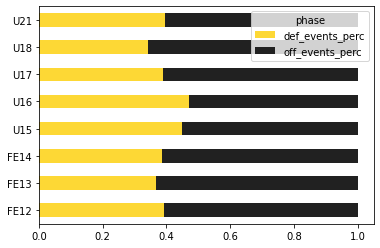

phase level  def_events_perc  off_events_perc
0      FE12         0.392473         0.607527
1      FE13         0.367647         0.632353
2      FE14         0.387097         0.612903
3       U15         0.449495         0.550505
4       U16         0.471910         0.528090
5       U17         0.390558         0.609442
6       U18         0.342256         0.657744
7       U21         0.396667         0.603333


In [18]:
# Comparison defensiv vs. offensiv events

# -- Group data to phases and level
def_off_comparison = events_df.groupby(['phase', 'level']).event_id.count().reset_index()
def_off_comparison = def_off_comparison.pivot(index = 'level', columns = 'phase', values = 'event_id').reset_index()

print(def_off_comparison)

def_off_comparison['total'] = def_off_comparison['def'] + def_off_comparison['off']
def_off_comparison['def'] = def_off_comparison['def'] / def_off_comparison['total']
def_off_comparison['off'] = def_off_comparison['off'] / def_off_comparison['total']
def_off_comparison = def_off_comparison.drop(columns = 'total')

def_off_comparison = def_off_comparison.rename(columns = {'def': 'def_events_perc', 'off': 'off_events_perc'})

# -- Create Plot of defensive and offensive plays according to the level
def_off_comparison.plot.barh(stacked = True, color=color_palette_dual)
ay = plt.subplot()
ay.set_yticks(range(len(def_off_comparison)))
ay.set_yticklabels(def_off_comparison['level'])

plt.show()

print(def_off_comparison)

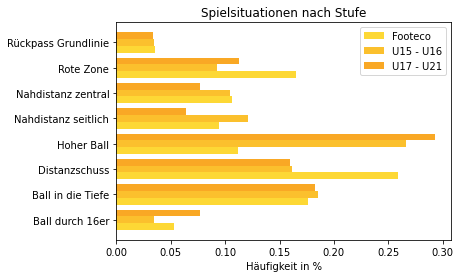

In [19]:
# Analysis of Defensive Events

## Creating a dataframe with solely defensive events and columns
defensive_df = events_df.loc[events_df.phase == 'def']
defensive_df = defensive_df.dropna(axis = 1, how = 'all')

## Compare defensive occurence of defensive events
group_def_events = defensive_df.groupby(['game_event', 'category']).event_id.count().reset_index()
group_def_events = group_def_events.pivot(index = 'game_event', columns = 'category', values = 'event_id').reset_index()

values = group_def_events.iloc[:,1:].columns

for x in group_def_events[values]:
     if x in values:
        group_def_events[x] = group_def_events[x] / group_def_events[x].sum()

### Create Plot
def create_y(t, w, n, d):
    return [t*x + w*n for x in range(d)]

footeco_y = create_y(3, 0.8, 1, 8)
t3_y = create_y(3, 0.8, 2, 8)
t4_y = create_y(3, 0.8, 3, 8)

plt.figure()
ay = plt.subplot()

plt.barh(footeco_y, group_def_events.Footeco, color=color_yellow)
plt.barh(t3_y, group_def_events.T3, color=color_yellow_2)
plt.barh(t4_y, group_def_events.T4, color=color_yellow_3)

middle_y = [ (a + b + c) / 3.0 for a, b, c in zip(footeco_y, t3_y, t4_y)]
ay.set_yticks(middle_y)
ay.set_yticklabels(group_def_events.game_event)
plt.xlabel('Häufigkeit in %')
plt.legend(['Footeco', 'U15 - U16', 'U17 - U21'])
plt.title('Spielsituationen nach Stufe')
plt.savefig("Spielsituationen_nach_Stufe.png", dpi=100)
plt.show()

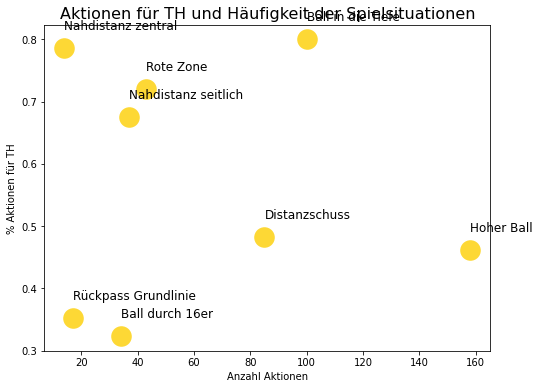

In [20]:
# Analysis of dangerous events, where goalkeeper needs to take action
critical_defensive_events = pd.merge(defensive_df, events_df, how='left', left_on='reference_event', right_on='event_id')
critical_defensive_events = critical_defensive_events[['event_id_x', 'game_event_x', 'decision_x', 'outcome_defensive_x', 'reference_event_x', 'category_x', 'phase_y', 'game_event_y', 'decision_y', 'outcome_defensive_y']]

space_defending_events = ['Hoher Ball', 'Rückpass Grundlinie', 'Ball in die Tiefe', 'Ball durch 16er']
critical_defensive_events.loc[(critical_defensive_events.phase_y == 'def') & (critical_defensive_events.game_event_y.isin(space_defending_events)), 'primary_event'] = critical_defensive_events.game_event_y

critical_defensive_events.loc[(critical_defensive_events.phase_y == 'def') & (critical_defensive_events.game_event_y.isin(space_defending_events)), 'primary_decision'] = critical_defensive_events.decision_y

critical_defensive_events.loc[~critical_defensive_events.game_event_y.isin(space_defending_events), 'primary_event'] = critical_defensive_events.game_event_x

critical_defensive_events.loc[~critical_defensive_events.game_event_y.isin(space_defending_events), 'primary_decision'] = critical_defensive_events.decision_x

reference_id_list = [x for x in critical_defensive_events.reference_event_x if str(x) != 'nan']

critical_defensive_events.loc[(critical_defensive_events.game_event_y.notnull()) & (critical_defensive_events.game_event_y.isin(space_defending_events)), 'defending_area'] = 'space'
critical_defensive_events.loc[(critical_defensive_events.game_event_y.isna()) & (critical_defensive_events.game_event_x.isin(space_defending_events)), 'defending_area'] = 'space'
critical_defensive_events.loc[(critical_defensive_events.game_event_y.isna()) & (~critical_defensive_events.game_event_x.isin(space_defending_events)), 'defending_area'] = 'goal'
critical_defensive_events.loc[(critical_defensive_events.game_event_y.notnull()) & (~critical_defensive_events.game_event_y.isin(space_defending_events)), 'defending_area'] = 'goal'

reference_id_list = [x for x in critical_defensive_events.reference_event_x if str(x) != 'nan']

critical_defensive_events =  critical_defensive_events[~(critical_defensive_events.event_id_x.isin(reference_id_list) & (critical_defensive_events.defending_area == 'space'))]

critical_defensive_events = critical_defensive_events.drop(columns=['game_event_x', 'decision_x', 'reference_event_x', 'phase_y', 'game_event_y', 'decision_y', 'outcome_defensive_y', 'phase_y'])
critical_defensive_events = critical_defensive_events.rename(columns={'event_id_x': 'event_id', 'outcome_defensive_x': 'outcome', 'category_x': 'category'})

critical_defensive_events.loc[(critical_defensive_events.outcome == 'Save' )| (critical_defensive_events.outcome == 'Tor'), 'gk_reaction'] = 'yes'
critical_defensive_events.loc[critical_defensive_events.outcome == 'None', 'gk_reaction'] = 'no'

critical_defensive_events = critical_defensive_events[(critical_defensive_events.category == 'T3') | (critical_defensive_events.category == 'T4')]


event_decision = critical_defensive_events[critical_defensive_events['primary_event'] == 'Nahdistanz zentral']
group_event_decision = event_decision.groupby(['outcome', 'primary_decision']).event_id.count().reset_index()
pivot_event_decision = group_event_decision.pivot(index='outcome', columns='primary_decision', values='event_id')

group_critical_events = critical_defensive_events.groupby(['primary_event', 'gk_reaction']).event_id.count().reset_index()
#pivot_event_decision = group_critical_events.pivot(index='outcome', columns='primary_decision', values='event_id').reset_index()
pivot_critical_events = group_critical_events.pivot(index='primary_event', columns='gk_reaction', values='event_id').reset_index()

#values = pivot_critical_events.iloc[:,0:].columns

#for x in pivot_critical_events[values]:
 #    if x in values:
  #      pivot_critical_events[x] = pivot_critical_events[x] / pivot_critical_events[x].sum()

pivot_critical_events['total'] = pivot_critical_events['no'] + pivot_critical_events['yes']
pivot_critical_events['perc of gk reaction'] = pivot_critical_events['yes'] / pivot_critical_events['total']
pivot_critical_events = pivot_critical_events.drop(columns=['no', 'yes'])

plt.figure(figsize=(8,6))
#plt.scatter('total', 'perc of gk reaction', data=pivot_critical_events, label='primary_event', c=color_yellow, s=500)
sns.scatterplot(x='total', y='perc of gk reaction', s=500, data=pivot_critical_events, color=color_yellow)

plt.xlabel('Anzahl Aktionen')
plt.ylabel('% Aktionen für TH')
plt.title('Aktionen für TH und Häufigkeit der Spielsituationen', fontsize=16)
for i, label in enumerate(pivot_critical_events.primary_event):
    plt.text(pivot_critical_events.total[i], pivot_critical_events['perc of gk reaction'][i]+0.03, label, fontsize=12)

plt.savefig('torhüter_aktionen.png')
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


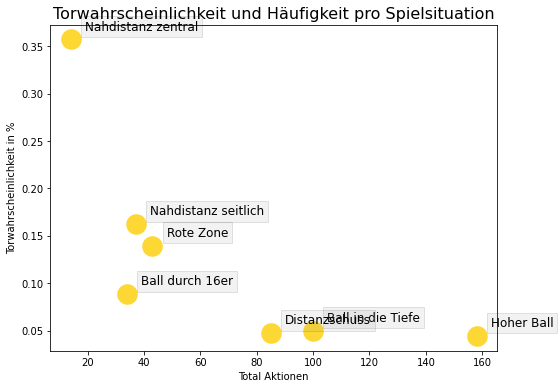

In [21]:
## Analysis of Goals

critical_defensive_events['is_goal'] = critical_defensive_events.outcome.apply(lambda x: 'yes' if x == "Tor" else 'no')
group_goal_events = critical_defensive_events.groupby(['primary_event', 'is_goal']).event_id.count().reset_index()
pivot_goal_events = group_goal_events.pivot(index='primary_event', columns='is_goal', values='event_id').reset_index()
pivot_goal_events['total_events'] = pivot_goal_events.no + pivot_goal_events.yes
pivot_goal_events['goals_in_perc'] = pivot_goal_events.yes / pivot_goal_events.total_events
pivot_goal_events = pivot_goal_events.drop(columns=['no', 'yes'])

plt.figure(figsize=[8,6])
sns.scatterplot(x='total_events', y='goals_in_perc', s=500, data=pivot_goal_events, color=color_yellow)

for i in range(pivot_goal_events.shape[0]):
    plt.text(x=pivot_goal_events.total_events[i]+5, 
        y=pivot_goal_events.goals_in_perc[i]+0.01, 
        s=pivot_goal_events.primary_event[i], 
        fontsize=12, 
        bbox=dict(facecolor='gray', alpha=0.1))

plt.title('Torwahrscheinlichkeit und Häufigkeit pro Spielsituation', fontsize=16)
plt.xlabel('Total Aktionen')
plt.ylabel('Torwahrscheinlichkeit in %')

plt.savefig('torwahrscheinlichkeit.png')
plt.show()

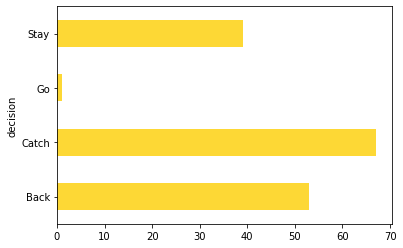

In [22]:
## Analysis von Hohen Bällen
crosses = defensive_df[(defensive_df.game_event == 'Hoher Ball') & ((defensive_df.category == 'T3') | (defensive_df.category == 'T4'))]
crosses_groupedby_decisions = crosses.groupby('decision').event_id.count()

crosses_groupedby_decisions.plot.barh(color=color_yellow )
plt.show()

In [23]:
## Analysis of close range shots
close_range_events = critical_defensive_events[critical_defensive_events.primary_event.isin(['Nahdistanz zentral', 'Nahdistanz seitlich', 'Rote Zone'])]
#print(close_range_events.head(5))


group_close_events = close_range_events.groupby(['primary_event', 'is_goal','primary_decision',]).event_id.count().reset_index()
#pivot_close_event = group_close_events.pivot(index=['primary_event', 'is_goal'], columns='primary_decision', values='event_id').reset_index()

#sns.barplot(data=group_close_events)
#plt.show


print(group_close_events)

          primary_event is_goal primary_decision  event_id
0   Nahdistanz seitlich      no               Go         9
1   Nahdistanz seitlich      no             Stay        22
2   Nahdistanz seitlich     yes               Go         2
3   Nahdistanz seitlich     yes             Stay         4
4    Nahdistanz zentral      no             Back         2
5    Nahdistanz zentral      no               Go         2
6    Nahdistanz zentral      no             Stay         5
7    Nahdistanz zentral     yes               Go         2
8    Nahdistanz zentral     yes             Stay         2
9             Rote Zone      no             Back         4
10            Rote Zone      no            Catch         1
11            Rote Zone      no               Go         3
12            Rote Zone      no             Stay        29
13            Rote Zone     yes             Back         1
14            Rote Zone     yes             Stay         5


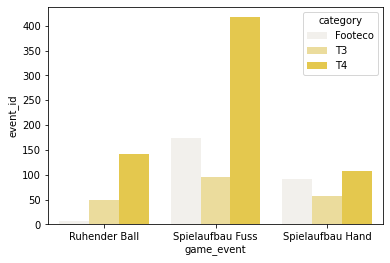

In [24]:
# Analysis of offensive events


group_off_events = offensive_df.groupby(['game_event', 'category']).event_id.count().reset_index()

sns.barplot(data=group_off_events, x = 'game_event', y = 'event_id', hue = 'category', color = color_yellow)
plt.show()

<AxesSubplot:xlabel='target_zone_offensive', ylabel='event_id'>

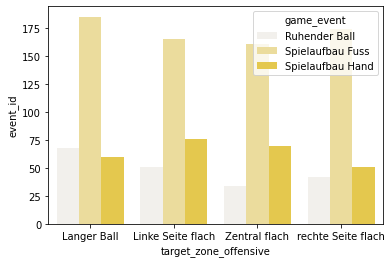

In [25]:
## Passing distribution

group_passing_distribution = offensive_df.groupby(['target_zone_offensive', 'game_event']).event_id.count().reset_index()

sns.barplot(data=group_passing_distribution, x='target_zone_offensive', y='event_id', hue='game_event', color=color_yellow)

success             target_zone_offensive under_pressure    no   yes  \
0                            Langer Ball                  15.0  16.0   
1               Langer Ball with pressure  with pressure  94.0  60.0   
2                      Linke Seite flach                   NaN  86.0   
3         Linke Seite flach with pressure  with pressure  20.0  59.0   
4                          Zentral flach                   4.0  80.0   
5             Zentral flach with pressure  with pressure  16.0  61.0   
6                     rechte Seite flach                   2.0  90.0   
7        rechte Seite flach with pressure  with pressure  21.0  61.0   

success  total_passes   accuracy  
0                31.0  51.612903  
1               154.0  38.961039  
2                 NaN        NaN  
3                79.0  74.683544  
4                84.0  95.238095  
5                77.0  79.220779  
6                92.0  97.826087  
7                82.0  74.390244  


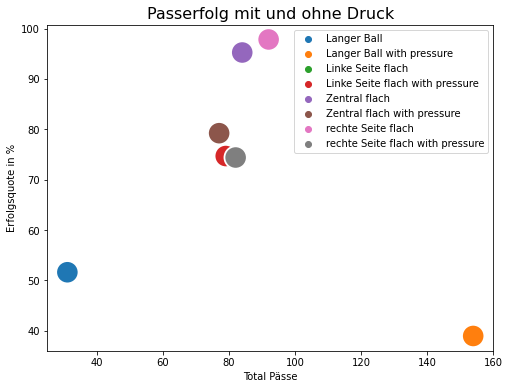

In [46]:
## Passing analysis

group_pressure_passing = passing_df.groupby(['target_zone_offensive', 'under_pressure', 'success']).event_id.count().reset_index()
pivot_pressure_passing = group_pressure_passing.pivot(index=['target_zone_offensive', 'under_pressure'], columns='success', values='event_id').reset_index()
pivot_pressure_passing['total_passes'] = pivot_pressure_passing['yes'] + pivot_pressure_passing['no']
pivot_pressure_passing['accuracy'] = pivot_pressure_passing.yes / pivot_pressure_passing.total_passes * 100
pivot_pressure_passing['target_zone_offensive'] = pivot_pressure_passing.target_zone_offensive.str.cat(pivot_pressure_passing.under_pressure, sep= ' ')
#pivot_pressure_passing = pivot_pressure_passing.drop(columns=['under_pressure', 'no', 'yes'])

print(pivot_pressure_passing)

plt.figure(figsize=[8, 6])
sns.scatterplot(x='total_passes', y='accuracy', s=500, data=pivot_pressure_passing, hue='target_zone_offensive')

plt.legend()
plt.title('Passerfolg mit und ohne Druck', fontsize=16)
plt.xlabel('Total Pässe')
plt.ylabel('Erfolgsquote in %')

plt.savefig('passgenauigkeit.png')
plt.show()